In [4]:
import numpy as np
#from scipy import linalg as LA

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt

import h5py
import pickle


import fastjet as fj
import Nsubjettiness as Nsub
import numpy as np
import pandas as pd

import glob as glob
import time

In [5]:
fn = '/home/jack/projects/EMD_VAE/compression_project/data/B_background/B_background_1.dat'
data = np.loadtxt(fn)

In [6]:
numevents = 50000
#numevents = 1000
events = [data[data[:,0] == i] for i in range(numevents)]

In [8]:
numpass=0
maxminpT = []

pass_indices = []

jet_def = fj.JetDefinition(fj.kt_algorithm, 1.0)


for n, event in enumerate(events):
    if n % 1000 == 0:
        print("Now processing event", n, "of", numevents)
    PIDs = event[:,1]
    pTs = event[:,2]
    eta = event[:,3]
    ismuon = np.logical_and(PIDs == 13,np.abs(eta) < 2.5)
    isantimuon = np.logical_and(PIDs == -13,np.abs(eta) < 2.5)
    if np.sum(ismuon) < 1 or np.sum(isantimuon) < 1:
        continue
    pTmu = np.max(pTs[ismuon])
    pTantimu = np.max(pTs[isantimuon])
    maxminpT += [np.min([pTmu,pTantimu])]
    if pTmu < 4.5 or pTantimu < 4.5:
        continue
    numpass += 1
    pass_indices += [n]
    
print("Numpass =",numpass,". Fraction =",1.*numpass/len(events))

Now processing event 0 of 50000
Now processing event 1000 of 50000
Now processing event 2000 of 50000
Now processing event 3000 of 50000
Now processing event 4000 of 50000
Now processing event 5000 of 50000
Now processing event 6000 of 50000
Now processing event 7000 of 50000
Now processing event 8000 of 50000
Now processing event 9000 of 50000
Now processing event 10000 of 50000
Now processing event 11000 of 50000
Now processing event 12000 of 50000
Now processing event 13000 of 50000
Now processing event 14000 of 50000
Now processing event 15000 of 50000
Now processing event 16000 of 50000
Now processing event 17000 of 50000
Now processing event 18000 of 50000
Now processing event 19000 of 50000
Now processing event 20000 of 50000
Now processing event 21000 of 50000
Now processing event 22000 of 50000
Now processing event 23000 of 50000
Now processing event 24000 of 50000
Now processing event 25000 of 50000
Now processing event 26000 of 50000
Now processing event 27000 of 50000
Now p

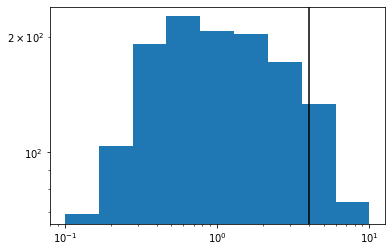

In [9]:
# fig=plt.figure()
# ax = fig.
plt.hist(maxminpT,bins=np.logspace(-1,1,10),log=True)
plt.axvline(4,color='black')
plt.semilogx()
plt.show()

In [10]:
out_data = np.zeros((numpass,50,4))

HT_muon = []
HT_tot = []

for n, index in enumerate(pass_indices):
    if n % 1000 == 0:
        print("Now processing event", n, "of", numpass)
    
    event = np.array(events[index])
    pTs = event[:,2]
    eta = event[:,3]
    
    PIDs = event[:,1]
    neutrinos = [12,14,16]
    
    ismuon = np.logical_and(PIDs == 13,np.abs(eta) < 2.5)
    isantimuon = np.logical_and(PIDs == -13,np.abs(eta) < 2.5)
        
    mu = np.argmax(pTs*ismuon)
    antimu = np.argmax(pTs*isantimuon)
    
    rejected = np.zeros(len(event), dtype=bool)
    rejected[mu] = True
    rejected[antimu] = True
    
    HT_tot += [np.sum(event[:,2])]
    
    pTs_muon = event[rejected,2]
    HT_muon += [np.sum(pTs_muon)]
    
    for neutPID in neutrinos:
        rejected += (np.abs(PIDs) == neutPID)
    
    event = event[np.logical_not(rejected)]
    
    
    pTs = event[:,2]
    etas = event[:,3]
    phis = event[:,4]
    Es = event[:,5]
    
    pxs = pTs*np.cos(phis)
    pys = pTs*np.sin(phis)
    pzs = pTs*np.sinh(etas)
    
    numparts = len(pTs)
    
    particles = []
    for i in range(numparts):
        particles += [fj.PseudoJet(pxs[i],pys[i],pzs[i],Es[i])]
    sequence = fj.ClusterSequence(particles,jet_def)
    reclustered = fj.sorted_by_pt(sequence.exclusive_jets(min(50,numparts)))
    
    
    numparts = min(50,len(reclustered))
    for j in range(numparts):
        particle = reclustered[j]
        out_data[n,j,0] = particle.pt()
        out_data[n,j,1] = particle.eta()
        out_data[n,j,2] = particle.phi() - np.pi
        out_data[n,j,3] = particle.E()
        
#     for j in range(numparts,50):
#         out_data[i,j,1] = jet.Eta
#         out_data[i,j,2] = jet.Phi

Now processing event 0 of 214


In [11]:
out_data = out_data.reshape((-1,50*4))

In [12]:
out_data

array([[ 2.91351884e+02, -6.36408614e-01, -1.85992920e+00, ...,
        -2.80653371e+00, -4.19198218e-01,  1.38756400e+01],
       [ 2.70014645e+01, -5.79419820e-01, -2.41609955e+00, ...,
         1.72480385e+00, -1.85501587e+00,  9.83722000e+00],
       [ 1.77454213e+01, -3.31806213e-01, -1.72623745e+00, ...,
         7.84327261e+00,  2.42740755e+00,  2.38513487e+03],
       ...,
       [ 1.37066150e+01, -3.47790447e-01,  2.10959959e+00, ...,
        -6.80786520e+00, -3.01585360e+00,  8.44189500e+02],
       [ 1.85744282e+02,  5.83018396e-01,  4.20063258e-01, ...,
        -3.45759068e+00, -7.85902915e-01,  4.01468310e+01],
       [ 1.23818250e+02, -6.94157308e-01, -2.21488021e+00, ...,
         2.25325000e+00,  2.79974265e+00,  7.61043000e+00]])

In [13]:
columns = []
for i in range(50):
    columns += ['pT' + str(i), 'eta' + str(i), 'phi' + str(i), 'E' + str(i)]

In [15]:
outstore = pd.HDFStore("/home/jack/projects/EMD_VAE/compression_project/data/B_background.h5")
dictionary = dict(zip(columns, out_data.T))
out_df = pd.DataFrame(dictionary,columns=columns)
outstore.append('particles',out_df)
outstore.close()

In [64]:
len(rejected)

285

In [61]:
event[]

array([[ 0.00000e+00,  2.11000e+02,  1.09504e+00,  9.46629e-01,
         2.96872e+00,  1.62942e+00],
       [ 0.00000e+00, -2.11000e+02,  3.76502e-01,  1.90269e+00,
         3.01310e+00,  1.29763e+00],
       [ 0.00000e+00,  2.11000e+02,  5.92605e-01, -5.32236e+00,
        -2.65813e+00,  6.07040e+01],
       ...,
       [ 0.00000e+00, -1.30000e+01,  2.75282e+00, -6.18138e-01,
        -1.55738e-01,  3.29740e+00],
       [ 0.00000e+00,  1.30000e+01,  6.14126e+00, -6.91735e-01,
        -1.64541e-01,  7.67081e+00],
       [ 0.00000e+00, -1.30000e+01,  4.83169e+00, -7.26780e-01,
        -1.35814e-01,  6.16583e+00]])

## No Cut

In [7]:
numpass=0

out_data = np.zeros((numpass,50,4))

HT_muon = []
HT_tot = []

for n, event in enumerate(events):
    index = n

    if n % 1000 == 0:
        print("Now processing event", n, "of", numpass)
    
    event = np.array(events[index])
    pTs = event[:,2]
    eta = event[:,3]
    
    PIDs = event[:,1]
    neutrinos = [12,14,16]
    
    ismuon = np.logical_and(PIDs == 13,np.abs(eta) < 2.5)
    isantimuon = np.logical_and(PIDs == -13,np.abs(eta) < 2.5)
        
    mu = np.argmax(pTs*ismuon)
    antimu = np.argmax(pTs*isantimuon)
    
    rejected = np.zeros(len(event), dtype=bool)
    rejected[mu] = True
    rejected[antimu] = True
    
    HT_tot += [np.sum(event[:,2])]
    
    pTs_muon = event[rejected,2]
    HT_muon += [np.sum(pTs_muon)]
    
    for neutPID in neutrinos:
        rejected += (np.abs(PIDs) == neutPID)
    
    event = event[np.logical_not(rejected)]
    
    
    pTs = event[:,2]
    etas = event[:,3]
    phis = event[:,4]
    Es = event[:,5]
    
    pxs = pTs*np.cos(phis)
    pys = pTs*np.sin(phis)
    pzs = pTs*np.sinh(etas)
    
    numparts = len(pTs)
    
    particles = []
    for i in range(numparts):
        particles += [fj.PseudoJet(pxs[i],pys[i],pzs[i],Es[i])]
    sequence = fj.ClusterSequence(particles,jet_def)
    reclustered = fj.sorted_by_pt(sequence.exclusive_jets(min(50,numparts)))
    
    
    numparts = min(50,len(reclustered))
    for j in range(numparts):
        particle = reclustered[j]
        out_data[n,j,0] = particle.pt()
        out_data[n,j,1] = particle.eta()
        out_data[n,j,2] = particle.phi() - np.pi
        out_data[n,j,3] = particle.E()
        
#     for j in range(numparts,50):
#         out_data[i,j,1] = jet.Eta
#         out_data[i,j,2] = jet.Phi

Now processing event 0 of 0


NameError: name 'jet_def' is not defined